# Big Data Programming Project


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import warnings
import joblib

warnings.filterwarnings("ignore")

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42

# 1. DATA COLLECTION & INGESTION


In [60]:
# CORRECT BASE PATH
base_path = "/Users/manishakumarishah/Desktop/csv_files"

agency = pd.read_csv(f"{base_path}/agency.csv")
routes = pd.read_csv(f"{base_path}/routes.csv")
stops = pd.read_csv(f"{base_path}/stops.csv")
calendar = pd.read_csv(f"{base_path}/calendar.csv")
calendar_dates = pd.read_csv(f"{base_path}/calendar_dates.csv")
frequencies = pd.read_csv(f"{base_path}/frequencies.csv")

print("Datasets ingested successfully")

Datasets ingested successfully


# 2. DATA STORAGE (RELATIONAL – SQLITE)

In [61]:

conn = sqlite3.connect("transport_data.db")

for name, df in {
    "agency": agency,
    "routes": routes,
    "stops": stops,
    "calendar": calendar,
    "calendar_dates": calendar_dates,
}.items():
    df.to_sql(name, conn, if_exists="replace", index=False)

print("Data persisted in relational SQLite database")

Data persisted in relational SQLite database


# 3. DATA CLEANING & FEATURE ENGINEERING


In [62]:

# Location cleaning
stops_clean = stops.dropna(subset=["stop_lat", "stop_lon"])[
    ["stop_id", "stop_lat", "stop_lon"]
]

# Date parsing (ONLY columns that exist)
calendar["start_date"] = pd.to_datetime(calendar["start_date"], format="%Y%m%d")
calendar["end_date"] = pd.to_datetime(calendar["end_date"], format="%Y%m%d")

# calendar_dates does NOT contain a 'date' column
calendar_dates["service_removed"] = (
    calendar_dates["exception_type"] == 2
).astype(int)

# Merge timetable with disruption indicators
calendar_full = calendar.merge(
    calendar_dates[["service_id", "service_removed"]],
    on="service_id",
    how="left"
)

calendar_full["service_removed"].fillna(0, inplace=True)

# Temporal features
calendar_full["start_month"] = calendar_full["start_date"].dt.month
calendar_full["end_month"] = calendar_full["end_date"].dt.month
calendar_full["service_duration"] = (
    calendar_full["end_date"] - calendar_full["start_date"]
).dt.days

assert calendar_full.isnull().sum().sum() == 0, "Missing values detected"

print("Data cleaning & feature engineering completed")

Data cleaning & feature engineering completed


# 4. MODEL DATASET

In [63]:
FEATURE_COLUMNS = [
    "monday", "tuesday", "wednesday",
    "thursday", "friday", "saturday", "sunday",
    "start_month", "end_month", "service_duration"
]

X = calendar_full[FEATURE_COLUMNS]
y = calendar_full["service_removed"]


# 5. CLASS DISTRIBUTION VISUALIZATION

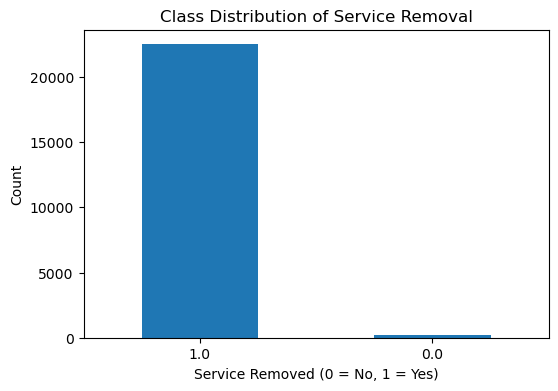

In [64]:
plt.figure(figsize=(6, 4))
y.value_counts().plot(kind="bar")
plt.xlabel("Service Removed (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.title("Class Distribution of Service Removal")
plt.xticks(rotation=0)
plt.show()

# 6. BASELINE MODEL

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE
)

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
baseline_pred = baseline.predict(X_test)

print("\n BASELINE MODEL ACCURACY:",
      accuracy_score(y_test, baseline_pred))


 BASELINE MODEL ACCURACY: 0.9900278633230679


# 7. ADVANCED ML PIPELINE + GRID SEARCH

In [66]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "lbfgs"]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("\n Best Hyperparameters:", grid.best_params_)

joblib.dump(best_model, "trained_disruption_model.pkl")



 Best Hyperparameters: {'clf__C': 0.1, 'clf__solver': 'lbfgs'}


['trained_disruption_model.pkl']

# 8. FINAL MODEL EVALUATION

In [67]:
# 8. FINAL MODEL EVALUATION

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n📊 FINAL MODEL PERFORMANCE")
print("Accuracy:", accuracy)
print("ROC-AUC:", roc_auc)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, zero_division=0))

cv_scores = cross_val_score(
    best_model, X, y,
    cv=cv,
    scoring="roc_auc"
)

print("Cross-validated ROC-AUC (mean):", cv_scores.mean())

pd.DataFrame([{
    "accuracy": accuracy,
    "roc_auc": roc_auc,
    "cv_roc_auc": cv_scores.mean()
}]).to_csv("model_evaluation_results.csv", index=False)



📊 FINAL MODEL PERFORMANCE
Accuracy: 0.9133304003519578
ROC-AUC: 0.9492232087621005

Confusion Matrix:
 [[  61    7]
 [ 584 6167]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.09      0.90      0.17        68
         1.0       1.00      0.91      0.95      6751

    accuracy                           0.91      6819
   macro avg       0.55      0.91      0.56      6819
weighted avg       0.99      0.91      0.95      6819

Cross-validated ROC-AUC (mean): 0.9339150946333511


# 9. CONFUSION MATRIX VISUALIZATION

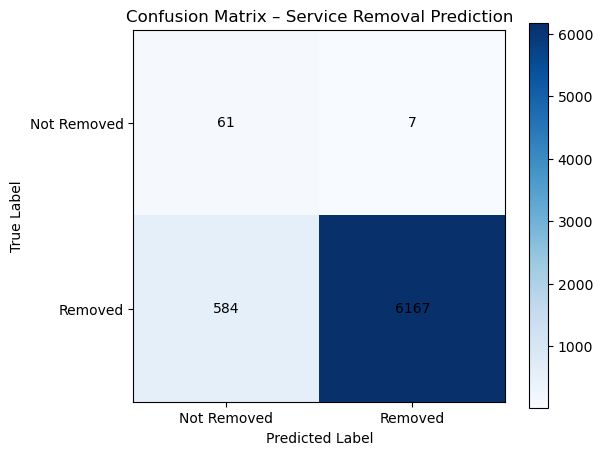

In [68]:
plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, cmap="Blues")
plt.title("Confusion Matrix – Service Removal Prediction")
plt.colorbar()
plt.xticks([0, 1], ["Not Removed", "Removed"])
plt.yticks([0, 1], ["Not Removed", "Removed"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j],
                 ha="center", va="center")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 10. ROC–AUC CURVE VISUALIZATION

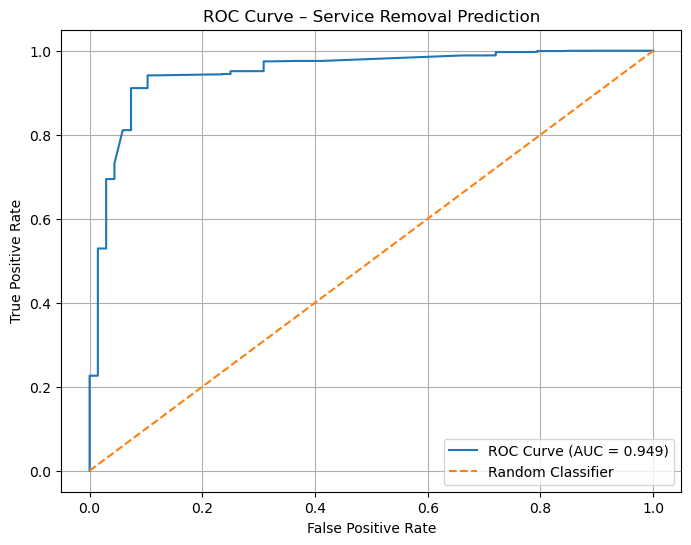

In [69]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Service Removal Prediction")
plt.legend()
plt.grid(True)
plt.show()

# 11. FEATURE IMPORTANCE VISUALIZATION

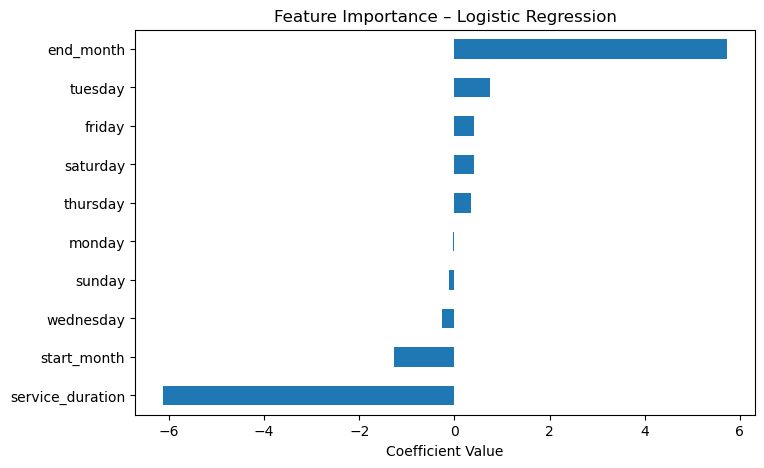

In [70]:
coefficients = pd.Series(
    best_model.named_steps["clf"].coef_[0],
    index=FEATURE_COLUMNS
).sort_values()

plt.figure(figsize=(8, 5))
coefficients.plot(kind="barh")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance – Logistic Regression")
plt.show()

# 12. SPATIAL VISUALIZATION (STOPS)


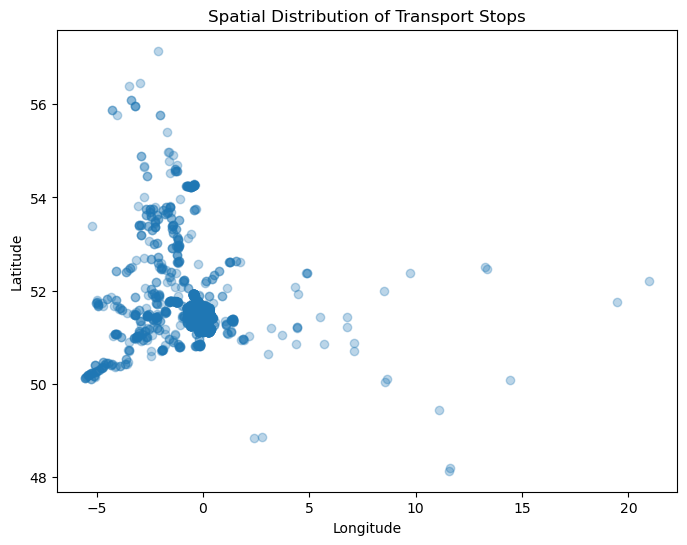

In [71]:
plt.figure(figsize=(8, 6))
plt.scatter(stops_clean["stop_lon"], stops_clean["stop_lat"], alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Distribution of Transport Stops")
plt.show()

# 13. PEAK TRAVEL HOURS

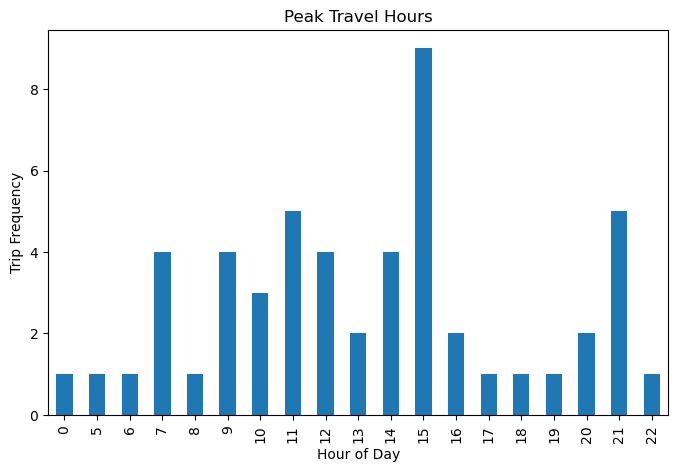

In [72]:
frequencies["start_time"] = pd.to_datetime(
    frequencies["start_time"], errors="coerce"
)
frequencies["hour"] = frequencies["start_time"].dt.hour

frequencies.groupby("hour").size().plot(kind="bar", figsize=(8, 5))
plt.xlabel("Hour of Day")
plt.ylabel("Trip Frequency")
plt.title("Peak Travel Hours")
plt.show()

# 14. SEASONAL TRENDS (FIXED & SAFE)

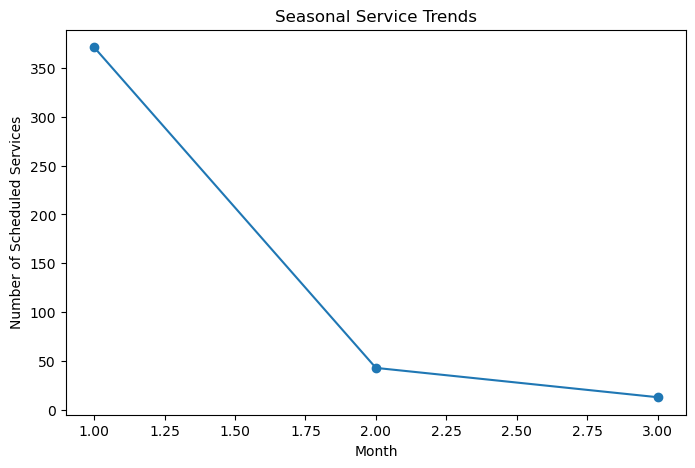

In [73]:
calendar["month"] = calendar["start_date"].dt.month

calendar.groupby("month").size().plot(
    kind="line", marker="o", figsize=(8, 5)
)
plt.xlabel("Month")
plt.ylabel("Number of Scheduled Services")
plt.title("Seasonal Service Trends")
plt.show()


# 15. ALGORITHMIC COMPLEXITY (B1)

In [74]:


# Logistic Regression training complexity:
# O(n × d)

conn.close()

print("\n🏁 FINAL ANALYTICS PIPELINE EXECUTED SUCCESSFULLY")


🏁 FINAL ANALYTICS PIPELINE EXECUTED SUCCESSFULLY
